In [104]:
import numpy as np
import cvxopt #Linear and Integer Programming Solver
import cvxopt.glpk
from cvxopt import matrix
import matplotlib.pyplot as plt

In [105]:
cvxopt.glpk.ilp?

In [106]:
#We have in total 88 binary variables
nbr_bricks = 22 #Defining number of bricks
nbr_SRs = 4 #Defining number of sales representatives
#The brick id goes from 1 to 22, but for computation simplicity, we will consider it from 0 to 21
#The sales representative id goes from 1 to 4, but for computation simplicity, we will consider it from 0 to 3

In [107]:
#Defining constant values
#Brick Index Value Array:
brick_index = np.array([0.1609, 0.1164, 0.1026, 0.1516, 0.0939, 0.1320, 0.0687, 0.0930, 0.2116, 0.2529, 0.0868, 0.0828, 0.0975, 0.8177, 0.4115, 0.3795, 0.0710, 0.0427, 0.1043, 0.0997, 0.1698, 0.2531])
#Travel Distance between SR offices and bricks Matrix:
distances = np.array([[16.16, 24.08, 24.32, 21.12] ,[19, 26.47, 27.24, 17.33] ,[25.29, 32.49, 33.42, 12.25] ,[0, 7.93, 8.31, 36.12] ,[3.07, 6.44, 7.56, 37.37] ,[1.22, 7.51, 8.19, 36.29] ,[2.8, 10.31, 10.95, 33.5] ,[2.87, 5.07, 5.67, 38.8] ,[3.8, 8.01, 7.41, 38.16] ,[12.35, 4.52, 4.35, 48.27] ,[11.11, 3.48, 2.97, 47.14] ,[21.99, 22.02, 24.07, 39.86] ,[8.82, 3.3, 5.36, 43.31] ,[7.93, 0, 2.07, 43.75] ,[9.34, 2.25, 1.11, 45.43] ,[8.31, 2.07, 0, 44.43] ,[7.31, 2.44, 1.11, 43.43] ,[7.55, 0.75, 1.53, 43.52] ,[11.13, 18.41, 19.26, 25.4] ,[17.49, 23.44, 24.76, 23.21] ,[11.03, 18.93, 19.28, 25.43] ,[36.12, 43.75, 44.43, 0]])

In [108]:
brick_index

array([0.1609, 0.1164, 0.1026, 0.1516, 0.0939, 0.132 , 0.0687, 0.093 ,
       0.2116, 0.2529, 0.0868, 0.0828, 0.0975, 0.8177, 0.4115, 0.3795,
       0.071 , 0.0427, 0.1043, 0.0997, 0.1698, 0.2531])

In [109]:
distances

array([[16.16, 24.08, 24.32, 21.12],
       [19.  , 26.47, 27.24, 17.33],
       [25.29, 32.49, 33.42, 12.25],
       [ 0.  ,  7.93,  8.31, 36.12],
       [ 3.07,  6.44,  7.56, 37.37],
       [ 1.22,  7.51,  8.19, 36.29],
       [ 2.8 , 10.31, 10.95, 33.5 ],
       [ 2.87,  5.07,  5.67, 38.8 ],
       [ 3.8 ,  8.01,  7.41, 38.16],
       [12.35,  4.52,  4.35, 48.27],
       [11.11,  3.48,  2.97, 47.14],
       [21.99, 22.02, 24.07, 39.86],
       [ 8.82,  3.3 ,  5.36, 43.31],
       [ 7.93,  0.  ,  2.07, 43.75],
       [ 9.34,  2.25,  1.11, 45.43],
       [ 8.31,  2.07,  0.  , 44.43],
       [ 7.31,  2.44,  1.11, 43.43],
       [ 7.55,  0.75,  1.53, 43.52],
       [11.13, 18.41, 19.26, 25.4 ],
       [17.49, 23.44, 24.76, 23.21],
       [11.03, 18.93, 19.28, 25.43],
       [36.12, 43.75, 44.43,  0.  ]])

In [110]:
#Creates a unique ID for each variable
def get_id(i,j):
    '''
    Associate a unique variable index given a 2-index (i,j) 
    '''
    assert(i>=0 and i<nbr_bricks)
    assert(j>=0 and j<nbr_SRs)
    
    return(4*i + j)

In [111]:
#Let's define the equality matrix
#We have in total 26 equality constraints
A = np.zeros((26,nbr_bricks*nbr_SRs))
A.shape
c=0 #Starting the constraint counter

In [112]:
#Defining sales representatives offices (center bricks)
for i in range(nbr_bricks):
    for j in range(nbr_SRs):
        #Define the office of Sales Representative 1 at brick 4
        if i+1==4 and j+1==1: 
            A[c,get_id(i,j)]=1
            c+=1
        #Define the office of Sales Representative 2 at brick 14
        if i+1==14 and j+1==2:
            A[c,get_id(i,j)]=1
            c+=1
        #Define the office of Sales Representative 3 at brick 16
        if i+1==16 and j+1==3:
            A[c,get_id(i,j)]=1
            c+=1
        #Define the office of Sales Representative 4 at brick 22
        if i+1==22 and j+1==4:
            A[c,get_id(i,j)]=1
            c+=1

In [113]:
#Now we add the constraint that each brick cannot be assign to more than 1 sales representative at a time
for i in range(nbr_bricks):
    for j in range(nbr_SRs):
        A[c,get_id(i,j)]=1 #Each brick can only be assigned to one SR at a time
    c+=1

In [114]:
A.shape

(26, 88)

In [115]:
#Now let's define the inequality matrix
#We have in total 184 inequality constraints (8 for the balanced workload and 176 for defining the 
#range [0,1] for the 88 variables)
G = np.zeros((184,nbr_bricks*nbr_SRs))
G.shape
c=0 #Starting the constraint counter

In [116]:
#We also need to create the h array that will represent all values on the right-hand side of the inequalities, in this case the workload threshold [0.8-1.2]
h=np.zeros(184)

In [117]:
#Defining balanced workload range
workload_l = 0.8
workload_h = 1.2

In [118]:
#Balanced Workload upper limit
for j in range(nbr_SRs):
    for i in range(nbr_bricks):
        G[c,get_id(i,j)]=brick_index[i]
        h[c]=workload_h
    c+=1

#Balanced Workload lower limit    
for j in range(nbr_SRs):
    for i in range(nbr_bricks):
        G[c,get_id(i,j)]=-brick_index[i]
        h[c]=-workload_l
    c+=1     

#Variables <= 1
for j in range(nbr_SRs):
    for i in range(nbr_bricks):
        G[c,get_id(i,j)]=1
        h[c]=1
        c+=1

#Variables >= 0    
for j in range(nbr_SRs):
    for i in range(nbr_bricks):
        G[c,get_id(i,j)]=-1
        h[c]=0
        c+=1       

In [119]:
G.shape

(184, 88)

In [120]:
#We initialize our distance travelled by SR'S objective
total_distance = np.zeros(nbr_bricks*nbr_SRs)

#Defining the distance objective function
for i in range(nbr_bricks):
    for j in range(nbr_SRs):
        total_distance[get_id(i,j)] = distances[i][j]

In [121]:
#Initializing disruption matrix
total_disruption = np.zeros(nbr_bricks*nbr_SRs)

#Finally, we define the disruption objective function
for i in range(nbr_bricks):
    for j in range(nbr_SRs):
        if (i+1==1 and j+1==4) or (i+1==2 and j+1==4) or (i+1==3 and j+1==4) or (i+1==5 and j+1==1) or (i+1==6 and j+1==1) \
        or (i+1==7 and j+1==1) or (i+1==8 and j+1==1) or (i+1==9 and j+1==3) or (i+1==10 and j+1==2) or (i+1==11 and j+1==2) \
        or (i+1==12 and j+1==2) or (i+1==13 and j+1==2) or (i+1==15 and j+1==1) or (i+1==17 and j+1==3) \
        or (i+1==18 and j+1==3) or (i+1==19 and j+1==4) or (i+1==20 and j+1==4) or (i+1==21 and j+1==4):
            total_disruption[get_id(i,j)]=-brick_index[i]

In [122]:
#We will first minimize the total disruption and then start adding the total distance as a new constraint in order to implement the e-constraint algorithm
Aeq = matrix(A)
b=matrix(np.ones(A.shape[0]))
G=matrix(G)
h=matrix(h)
cost_disrup=matrix(total_disruption) #total disruption as cost function
cost_distance = matrix(total_distance)
#B=set(range(A.shape[1])) #Set of binary variables
#We use a factor of 0.00001 in order to remove weekly non-dominated solutions
#(status, solution) = cvxopt.glpk.ilp(c=cost_disrup+0.00001*cost_distance,G=G,h=h,A=Aeq,b=b,B=B)
(status, solution) = cvxopt.glpk.ilp(c=cost_disrup+0.00001*cost_distance,G=G,h=h,A=Aeq,b=b)

In [123]:
status

'optimal'

In [124]:
def printsol_decimal(sol):
    header = " "*10 + "SR1 SR2 SR3 SR4"
    print(header)
    sep = " "*9 + "+---+---+---+---+"
    print(sep)
    for i in range(nbr_bricks):
        if i+1<10:
            print("Brick {}  ".format(i+1),end='')
        else:
            print("Brick {} ".format(i+1),end='')
        for j in range(nbr_SRs):
            print(" ",end='')
            if (sol[get_id(i,j)]>0.01):
                print("{:3.1f}".format(sol[get_id(i,j)]),end='')
            else:
                print("   ",end='')
   
        print("")
        print(sep)
        
printsol_decimal(solution)

          SR1 SR2 SR3 SR4
         +---+---+---+---+
Brick 1               1.0
         +---+---+---+---+
Brick 2               1.0
         +---+---+---+---+
Brick 3               1.0
         +---+---+---+---+
Brick 4   1.0            
         +---+---+---+---+
Brick 5   1.0            
         +---+---+---+---+
Brick 6   1.0            
         +---+---+---+---+
Brick 7   1.0            
         +---+---+---+---+
Brick 8   1.0            
         +---+---+---+---+
Brick 9           1.0    
         +---+---+---+---+
Brick 10      0.8 0.2    
         +---+---+---+---+
Brick 11          1.0    
         +---+---+---+---+
Brick 12      1.0        
         +---+---+---+---+
Brick 13      1.0        
         +---+---+---+---+
Brick 14      1.0        
         +---+---+---+---+
Brick 15  1.0            
         +---+---+---+---+
Brick 16          1.0    
         +---+---+---+---+
Brick 17          1.0    
         +---+---+---+---+
Brick 18          1.0    
         +---+---+--

In [125]:
disruption_partial = cost_disrup.T*solution

In [126]:
sum_disrupt_base=0
for i in range(nbr_bricks):
    if i+1 not in (4,14,16,22):
        sum_disrupt_base +=  brick_index[i]

In [127]:
#Computing the disruption value for the given conditions
disruption_final = disruption_partial[0] + sum_disrupt_base

In [128]:
#This is the value of disruption when considering it as the only objective function
disruption_final

0.1376999999999997

In [129]:
#We initialize our distance travelled by SR'S (distance_final) for the first time before entering the iteration 
#process because the first time the algorithm does not have the value beforehand
distance_final = cost_distance.T*solution

In [130]:
distance_final[0]

186.8657848952155

## Now in order to implement the epsilon-method we need to start iterating while adding a new constraint based on the second objective function (Total distance)

In [131]:
distance_final_points = []
disruption_final_points = []
solution_list = []

disruption_final_points.append(disruption_final)
distance_final_points.append(distance_final[0])
solution_list.append(solution)

nbr_iter = 1000

for k in range(nbr_iter):
    
    G = np.zeros((185,nbr_bricks*nbr_SRs))
    G.shape
    c=0 #Starting the constraint counter
    #We also need to create the h array that will represent all values on the right-hand side of the inequalities
    h=np.zeros(185) # 8(workload balanced) + 176([0,1] range for variables) + 1 (epsilon constraint)  

    #Balanced Workload upper limit    
    for j in range(nbr_SRs):
        for i in range(nbr_bricks):
            G[c,get_id(i,j)]=brick_index[i]
            h[c]=workload_h
        c+=1

    #Balanced Workload lower limit
    for j in range(nbr_SRs):
        for i in range(nbr_bricks):
            G[c,get_id(i,j)]=-brick_index[i]
            h[c]=-workload_l
        c+=1   
        
    #Variables <= 1        
    for j in range(nbr_SRs):
        for i in range(nbr_bricks):
            G[c,get_id(i,j)]=1
            h[c]=1
            c+=1

    #Variables >= 0         
    for j in range(nbr_SRs):
        for i in range(nbr_bricks):
            G[c,get_id(i,j)]=-1
            h[c]=0
            c+=1    
    
    #Epsilon Constraint    
    for i in range(nbr_bricks):
        for j in range(nbr_SRs):
            G[c,get_id(i,j)] = distances[i][j]
    h[c]=distance_final[0]-1 #Epsilon = 1       
    c+=1
    
    Aeq = matrix(A)
    b=matrix(np.ones(A.shape[0]))
    G=matrix(G)
    h=matrix(h)
    cost_disrup=matrix(total_disruption) #total disruption as cost function
    #B=set(range(A.shape[1])) #Set of binary variables
    #We use a factor of 0.00001 in order to remove weekly non-dominated solutions
    (status, solution) = cvxopt.glpk.ilp(c=cost_disrup+0.00001*cost_distance,G=G,h=h,A=Aeq,b=b)

    print("Status for iteration {}: {}".format(k+1,status))
    if status != 'optimal':
        break
    
    solution_list.append(solution) #Saving the current solution in a list
    
    #Disruption
    disruption_partial = cost_disrup.T*solution    
    sum_disrupt_base=0
    for i in range(nbr_bricks):
        if i+1 not in (4,14,16,22):
            sum_disrupt_base +=  brick_index[i]    
    #Computing the disruption value for the given conditions
    disruption_final = disruption_partial[0] + sum_disrupt_base    
    
    #Distance
    #For this particular condition let's compute the distance travelled by SR'S value    
    total_distance = np.zeros(nbr_bricks*nbr_SRs)

    for i in range(nbr_bricks):
        for j in range(nbr_SRs):
            total_distance[get_id(i,j)] = distances[i][j]    
            
    cost_distance = matrix(total_distance)
    distance_final = cost_distance.T*solution
    
    #Storing objective values
    disruption_final_points.append(disruption_final)
    distance_final_points.append(distance_final[0])    

Status for iteration 1: optimal
Status for iteration 2: optimal
Status for iteration 3: optimal
Status for iteration 4: optimal
Status for iteration 5: optimal
Status for iteration 6: optimal
Status for iteration 7: optimal
Status for iteration 8: optimal
Status for iteration 9: optimal
Status for iteration 10: optimal
Status for iteration 11: optimal
Status for iteration 12: optimal
Status for iteration 13: optimal
Status for iteration 14: optimal
Status for iteration 15: optimal
Status for iteration 16: optimal
Status for iteration 17: optimal
Status for iteration 18: optimal
Status for iteration 19: optimal
Status for iteration 20: optimal
Status for iteration 21: optimal
Status for iteration 22: optimal
Status for iteration 23: optimal
Status for iteration 24: optimal
Status for iteration 25: optimal
Status for iteration 26: optimal
Status for iteration 27: optimal
Status for iteration 28: optimal
Status for iteration 29: optimal
Status for iteration 30: optimal
Status for iteratio

In [132]:
disruption_final_points

[0.1376999999999997,
 0.14500903994393788,
 0.15231807988787693,
 0.15962711983181554,
 0.1669361597757537,
 0.17424519971969232,
 0.18155423966363093,
 0.18886327960756955,
 0.19617231955150816,
 0.20348135949544632,
 0.21079039943938493,
 0.21809943938332355,
 0.22540847932726216,
 0.23271751927120077,
 0.24002655921513938,
 0.2506079166666719,
 0.26239958333333835,
 0.27419125000000566,
 0.2859829166666725,
 0.29777458333333895,
 0.3095662500000067,
 0.32135791666667357,
 0.33314958333334044,
 0.3463710247350158,
 0.39637102473501873,
 0.44637102473502144,
 0.49637102473502415,
 0.5463710247350273,
 0.5963710247350302,
 0.6463710247350325,
 0.6963710247350352,
 0.7470693371825723,
 0.8034459650262071,
 0.8619418771963179,
 0.9205568356450744,
 0.988447838224846]

In [133]:
distance_final_points

[186.8657848952155,
 185.86578489521548,
 184.86578489521546,
 183.86578489521543,
 182.8657848952154,
 181.86578489521537,
 180.86578489521534,
 179.8657848952153,
 178.86578489521528,
 177.86578489521526,
 176.86578489521523,
 175.8657848952152,
 174.86578489521517,
 173.8657848952151,
 172.86578489521509,
 171.86578489521506,
 170.86578489521503,
 169.865784895215,
 168.86578489521497,
 167.86578489521494,
 166.8657848952149,
 165.8657848952149,
 164.86578489521486,
 163.8657848952148,
 162.86578489521474,
 161.8657848952147,
 160.86578489521463,
 159.86578489521457,
 158.86578489521452,
 157.86578489521446,
 156.86578489521443,
 155.86578489521438,
 154.8657848952143,
 153.86578489521423,
 152.8657848952142,
 151.86578489521412]

## Efficient Solutions

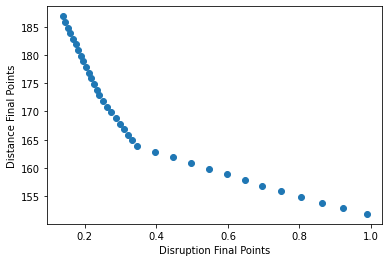

In [134]:
plt.xlabel('Disruption Final Points')
plt.ylabel('Distance Final Points')
plt.scatter(disruption_final_points, distance_final_points)

In [135]:
non_dominated_solutions = list(zip([round(num,2) for num in disruption_final_points], [round(num,2) for num in distance_final_points]))

In [136]:
non_dominated_solutions

[(0.14, 186.87),
 (0.15, 185.87),
 (0.15, 184.87),
 (0.16, 183.87),
 (0.17, 182.87),
 (0.17, 181.87),
 (0.18, 180.87),
 (0.19, 179.87),
 (0.2, 178.87),
 (0.2, 177.87),
 (0.21, 176.87),
 (0.22, 175.87),
 (0.23, 174.87),
 (0.23, 173.87),
 (0.24, 172.87),
 (0.25, 171.87),
 (0.26, 170.87),
 (0.27, 169.87),
 (0.29, 168.87),
 (0.3, 167.87),
 (0.31, 166.87),
 (0.32, 165.87),
 (0.33, 164.87),
 (0.35, 163.87),
 (0.4, 162.87),
 (0.45, 161.87),
 (0.5, 160.87),
 (0.55, 159.87),
 (0.6, 158.87),
 (0.65, 157.87),
 (0.7, 156.87),
 (0.75, 155.87),
 (0.8, 154.87),
 (0.86, 153.87),
 (0.92, 152.87),
 (0.99, 151.87)]

## Discriminate solutions by an additive model

In [137]:
#Function to normalize data to the range [0,1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [138]:
#Using an additive aggregation function 
#with weights = 0.5 for both criteria Disruption and Distance
additive_values = []

for i in range(len(disruption_final_points)):
    weighted_value = 0.5*NormalizeData(disruption_final_points)[i] + 0.5*NormalizeData(distance_final_points)[i]
    additive_values.append(weighted_value)

In [139]:
#Final additive values
additive_values

[0.5,
 0.4900099416157978,
 0.48001988323159617,
 0.4700298248473942,
 0.46003976646319206,
 0.4500497080789901,
 0.44005964969478817,
 0.43006959131058625,
 0.42007953292638434,
 0.41008947454218214,
 0.4000994161579802,
 0.3901093577737783,
 0.38011929938957634,
 0.37012924100537403,
 0.3601391826211721,
 0.3520723248379978,
 0.3447167878250645,
 0.33736125081213164,
 0.3300057137991986,
 0.32265017678626523,
 0.3152946397733323,
 0.3079391027603996,
 0.3005835657474665,
 0.2940683333881374,
 0.3091685297997289,
 0.32426872621132025,
 0.3393689226229116,
 0.3544691190345032,
 0.36956931544609467,
 0.3846695118576857,
 0.3997697082692775,
 0.4152803156253101,
 0.43412817236415935,
 0.4542215711022094,
 0.4743849355065225,
 0.5]

In [140]:
#Rounding values
[round(num,4) for num in additive_values]

[0.5,
 0.49,
 0.48,
 0.47,
 0.46,
 0.45,
 0.4401,
 0.4301,
 0.4201,
 0.4101,
 0.4001,
 0.3901,
 0.3801,
 0.3701,
 0.3601,
 0.3521,
 0.3447,
 0.3374,
 0.33,
 0.3227,
 0.3153,
 0.3079,
 0.3006,
 0.2941,
 0.3092,
 0.3243,
 0.3394,
 0.3545,
 0.3696,
 0.3847,
 0.3998,
 0.4153,
 0.4341,
 0.4542,
 0.4744,
 0.5]

In [141]:
#Index of the best aggregated solution
np.argmin(additive_values) 

23

In [142]:
non_dominated_solutions[np.argmin(additive_values)]

(0.35, 163.87)

## Printing Solution Minimum Disruption and Distance

In [143]:
#Best solution by using additive model
printsol_decimal(solution_list[np.argmin(additive_values)])

          SR1 SR2 SR3 SR4
         +---+---+---+---+
Brick 1               1.0
         +---+---+---+---+
Brick 2               1.0
         +---+---+---+---+
Brick 3               1.0
         +---+---+---+---+
Brick 4   1.0            
         +---+---+---+---+
Brick 5   1.0            
         +---+---+---+---+
Brick 6   1.0            
         +---+---+---+---+
Brick 7   1.0            
         +---+---+---+---+
Brick 8   1.0            
         +---+---+---+---+
Brick 9           1.0    
         +---+---+---+---+
Brick 10      0.8 0.2    
         +---+---+---+---+
Brick 11          1.0    
         +---+---+---+---+
Brick 12      1.0        
         +---+---+---+---+
Brick 13      1.0        
         +---+---+---+---+
Brick 14      1.0        
         +---+---+---+---+
Brick 15  1.0            
         +---+---+---+---+
Brick 16          1.0    
         +---+---+---+---+
Brick 17          1.0    
         +---+---+---+---+
Brick 18          1.0    
         +---+---+--

## Printing Solution Minimum Disruption

In [144]:
printsol_decimal(solution_list[0])

          SR1 SR2 SR3 SR4
         +---+---+---+---+
Brick 1               1.0
         +---+---+---+---+
Brick 2               1.0
         +---+---+---+---+
Brick 3               1.0
         +---+---+---+---+
Brick 4   1.0            
         +---+---+---+---+
Brick 5   1.0            
         +---+---+---+---+
Brick 6   1.0            
         +---+---+---+---+
Brick 7   1.0            
         +---+---+---+---+
Brick 8   1.0            
         +---+---+---+---+
Brick 9           1.0    
         +---+---+---+---+
Brick 10      0.8 0.2    
         +---+---+---+---+
Brick 11          1.0    
         +---+---+---+---+
Brick 12      1.0        
         +---+---+---+---+
Brick 13      1.0        
         +---+---+---+---+
Brick 14      1.0        
         +---+---+---+---+
Brick 15  1.0            
         +---+---+---+---+
Brick 16          1.0    
         +---+---+---+---+
Brick 17          1.0    
         +---+---+---+---+
Brick 18          1.0    
         +---+---+--

## Printing Solution Minimum Distance

In [145]:
printsol_decimal(solution_list[-1])

          SR1 SR2 SR3 SR4
         +---+---+---+---+
Brick 1               1.0
         +---+---+---+---+
Brick 2               1.0
         +---+---+---+---+
Brick 3               1.0
         +---+---+---+---+
Brick 4   1.0            
         +---+---+---+---+
Brick 5   1.0            
         +---+---+---+---+
Brick 6   1.0            
         +---+---+---+---+
Brick 7   1.0            
         +---+---+---+---+
Brick 8   1.0            
         +---+---+---+---+
Brick 9   1.0            
         +---+---+---+---+
Brick 10      0.8 0.2    
         +---+---+---+---+
Brick 11          1.0    
         +---+---+---+---+
Brick 12      1.0        
         +---+---+---+---+
Brick 13      1.0        
         +---+---+---+---+
Brick 14      1.0        
         +---+---+---+---+
Brick 15          1.0    
         +---+---+---+---+
Brick 16          1.0    
         +---+---+---+---+
Brick 17          1.0    
         +---+---+---+---+
Brick 18      0.2 0.8    
         +---+---+--

## Printing Initial Solution

In [146]:
initial_state = np.array([[0],[0],[0],[1], [0],[0],[0],[1], [0],[0],[0],[1], [1],[0],[0],[0], [1],[0],[0],[0], [1],[0],[0],[0], [1],[0],[0],[0], [1],[0],[0],[0], [0],[0],[1],[0], [0],[1],[0],[0], [0],[1],[0],[0], [0],[1],[0],[0], [0],[1],[0],[0], [0],[1],[0],[0], [1],[0],[0],[0], [0],[0],[1],[0], [0],[0],[1],[0], [0],[0],[1],[0], [0],[0],[0],[1], [0],[0],[0],[1], [0],[0],[0],[1], [0],[0],[0],[1]])

In [147]:
initial_state.shape

(88, 1)

In [148]:
initial_state_matrix = matrix(initial_state)

In [149]:
initial_state_matrix

<88x1 matrix, tc='i'>

In [150]:
printsol_decimal(initial_state_matrix)

          SR1 SR2 SR3 SR4
         +---+---+---+---+
Brick 1               1.0
         +---+---+---+---+
Brick 2               1.0
         +---+---+---+---+
Brick 3               1.0
         +---+---+---+---+
Brick 4   1.0            
         +---+---+---+---+
Brick 5   1.0            
         +---+---+---+---+
Brick 6   1.0            
         +---+---+---+---+
Brick 7   1.0            
         +---+---+---+---+
Brick 8   1.0            
         +---+---+---+---+
Brick 9           1.0    
         +---+---+---+---+
Brick 10      1.0        
         +---+---+---+---+
Brick 11      1.0        
         +---+---+---+---+
Brick 12      1.0        
         +---+---+---+---+
Brick 13      1.0        
         +---+---+---+---+
Brick 14      1.0        
         +---+---+---+---+
Brick 15  1.0            
         +---+---+---+---+
Brick 16          1.0    
         +---+---+---+---+
Brick 17          1.0    
         +---+---+---+---+
Brick 18          1.0    
         +---+---+--